# Test Review Notebook

This is a test notebook to try out `ReviewNB` as a viable solution for a hackathon (among other things). Here, I will load in some POP output from Cheyenne and make some simple plots.

In [1]:
%matplotlib inline
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

We'll be using an air-sea CO$_{2}$ flux file from a POP hindcast run.

In [2]:
basePath = '/glade/p/cesm/community/CESM-DPLE/CESM-DPLE_POPCICEhindcast/'
fileName = 'g.e11_LENS.GECOIAF.T62_g16.009.pop.h.FG_CO2.024901-031612.nc'
ds = xr.open_dataset(basePath + fileName, decode_times=False)['FG_CO2']

In [3]:
print(ds)

<xarray.DataArray 'FG_CO2' (time: 816, nlat: 384, nlon: 320)>
[100270080 values with dtype=float32]
Coordinates:
    TLAT     (nlat, nlon) float64 ...
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
  * time     (time) float64 9.092e+04 9.094e+04 ... 1.157e+05 1.157e+05
Dimensions without coordinates: nlat, nlon
Attributes:
    grid_loc:      2110
    long_name:     DIC Surface Gas Flux
    cell_methods:  time: mean
    units:         mmol/m^3 cm/s


`xarray` doesn't do a great job at loading in `cftimes`, but it's getting better. Although this might be an issue with how POP offsets their time. Here I use the `cftime_range` to keep this in model years (as opposed to translating it to real time).

In [4]:
ds['time'] = xr.cftime_range('0249-01', '0317-01', freq='M')
print(ds.time)

<xarray.DataArray 'time' (time: 816)>
array([cftime.DatetimeGregorian(249, 1, 31, 0, 0, 0, 0, 2, 31),
       cftime.DatetimeGregorian(249, 2, 28, 0, 0, 0, 0, 2, 59),
       cftime.DatetimeGregorian(249, 3, 31, 0, 0, 0, 0, 5, 90), ...,
       cftime.DatetimeGregorian(316, 10, 31, 0, 0, 0, 0, 2, 305),
       cftime.DatetimeGregorian(316, 11, 30, 0, 0, 0, 0, 4, 335),
       cftime.DatetimeGregorian(316, 12, 31, 0, 0, 0, 0, 0, 366)], dtype=object)
Coordinates:
  * time     (time) object 0249-01-31 00:00:00 ... 0316-12-31 00:00:00


Convert from mmol/m$^{3}$ cm/s to mol/m$^{2}$/yr and flip sign so that positive is out of ocean.

In [5]:
fac = ((-1 * 3600 * 24 * 365.25) / (1000 * 100))
ds *= fac

Let's create monthly climatologies over this model run.

In [6]:
clim = ds.groupby('time.month').mean('time')

/glade/u/home/rbrady/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


To keep things simple, we can use `xarray`'s native plotting module.

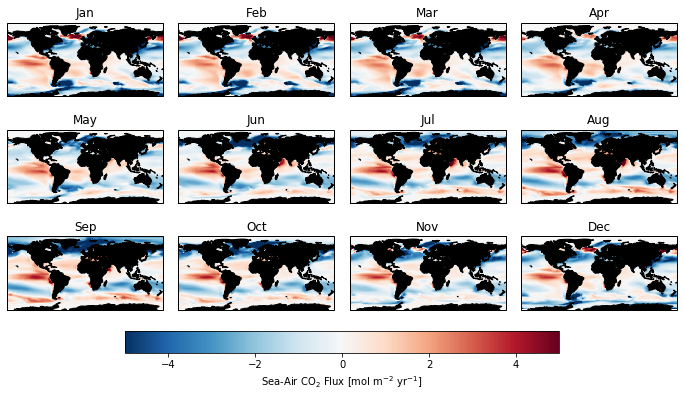

In [7]:
months = ['Jan', 'Feb', 'Mar', 'Apr',
          'May', 'Jun', 'Jul', 'Aug',
          'Sep', 'Oct', 'Nov', 'Dec']

f, axs = plt.subplots(figsize=(12,8), nrows=3, ncols=4, 
                     subplot_kw=dict(projection=ccrs.PlateCarree()),
                     gridspec_kw=dict(hspace=-0.4, wspace=0.1))

for i, ax in enumerate(axs.ravel()):
    p = ax.pcolormesh(clim.TLONG, clim.TLAT, clim.isel(month=i),
                      vmin=-5, vmax=5, cmap='RdBu_r')
    ax.add_feature(cfeature.LAND, color='k', zorder=3)
    ax.set_title(months[i])

cb = f.colorbar(p, ax=axs.ravel().tolist(), fraction=0.05, orientation='horizontal',
                pad=0.05)
cb.set_label('Sea-Air CO$_{2}$ Flux [mol m$^{-2}$ yr$^{-1}$]')